# Meridional circulations using localized streamfunction 

In [1]:
## Standard Stuff
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

## HEALPix Specific
#import healpix as hp
import easygems.healpix as egh
#import easygems.remap as egrp
import healpy

import intake     # For catalogs

import warnings
warnings.filterwarnings('ignore')

import glob
import constants as const

from windspharm.xarray import VectorWind
from scipy import integrate
from scipy.interpolate import NearestNDInterpolator 
import sys
sys.path.append("../../src/")
import toolbox as toolbox

In [83]:
def load_model(model):
    # load
    ds = xr.open_mfdataset(glob.glob('helmholtz_monthly_winds/{}_20*-*.nc'.format(model)), concat_dim='time', combine='nested')
    ds = ds.transpose('plev','lat','lon','time')
    month = np.array([float(tt[5:]) for tt in ds.time.values])
    ds['time'] = (('time'), month)

    # make sure pressure is in hPa
    if ds.plev.max() > 1010:
        ds['plev'] = ds.plev / 100

    # standardize pressure grid
    levs = np.array([5., 10., 20., 30., 50., 70., 100., 150., 200., 250., 300., 400., 500., 
                     600., 700., 750., 800., 850., 875., 900., 925., 950., 975., 1000.])
    ds = ds.interp(plev = levs)
        
    # local meridional streamfunction
    int = integrate.cumulative_trapezoid(ds.vdiv, ds.plev, axis=0, initial=0)
    ds['psi_loc'] = (1/const.g) * xr.DataArray(int, coords={'plev':ds.plev, 'lat':ds.lat, 'lon':ds.lon, 'time':ds.time})

    return ds

In [84]:
dsets = []
models = ['xsh24_coarse', 'scream_ne120', 'icon_3hp003', 'ifs_fesom','ERA5', 'MERRA2','JRA3Q',]
for model in models:
    dsets.append(load_model(model))
ds = xr.concat(dsets, dim='model')
ds['model'] = models
ds = ds.transpose('plev','lat','lon','time','model')

In [85]:
def get_zonal_slice(lon0, lon1, v):
    factor = ((lon1-lon0)/360) * 2 * np.pi * const.a * np.cos(np.deg2rad(ds.lat)) / const.g
    vbar = v.sel(lon=slice(lon0, lon1)).mean('lon')
    v_int = integrate.cumulative_trapezoid(vbar, ds.plev, axis=0, initial=0)
    if 'time' in v.sizes:
        psi = factor * xr.DataArray(v_int, coords={'plev':ds.plev, 'lat':ds.lat, 'time':ds.time, 'model':ds.model})
    else:
        psi = factor * xr.DataArray(v_int, coords={'plev':ds.plev, 'lat':ds.lat, 'model':ds.model})
    return psi
    

# eastern pacific JJA

In [92]:
lon0 = 230
lon1 = 260
months = [7]
epac_jja_psi = get_zonal_slice(lon0, lon1, ds.vdiv.sel(time=months).mean('time')).compute()
epac_jja_va = ds.v.sel(lon=slice(lon0, lon1), time=months).mean(('time','lon')).compute()

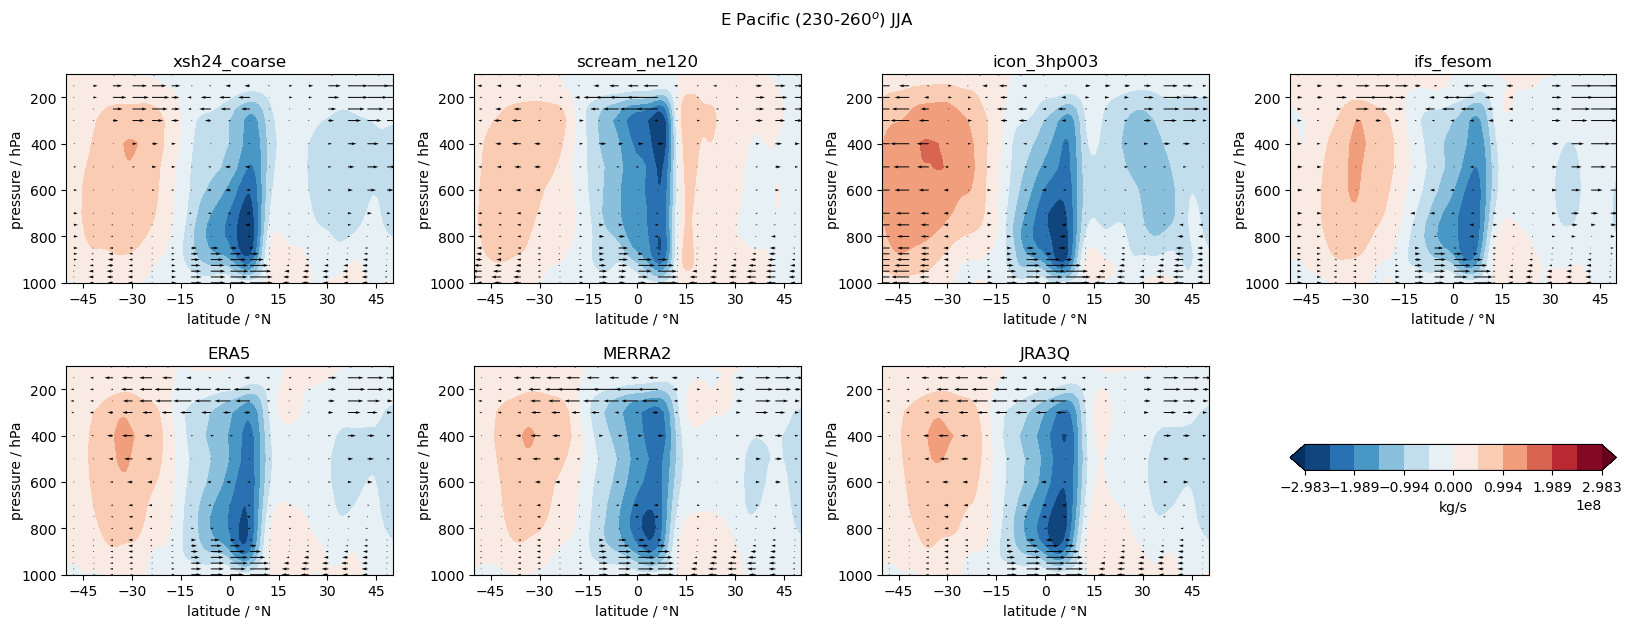

In [94]:
quiver_skip = 12
psi = epac_jja_psi
v = epac_jja_va
maxval = abs(psi).max().values
levs = np.linspace(-maxval, maxval, 13)

fig, axes = plt.subplots(2,4, figsize=(20,6.5),)
fig.subplots_adjust(hspace=0.4, wspace=0.25)
for i in range(psi.sizes['model']):
    plt.sca(axes.flatten()[i])
    
    contour = plt.contourf(psi.lat, psi.plev, psi.isel(model=i).T, levels=levs, cmap='RdBu_r', extend='both')
    
    plt.quiver(v.lat[::quiver_skip],
               v.plev,
               v.isel(model=i)[:,::quiver_skip],
               0*v.isel(model=i)[:,::quiver_skip],
               scale=1,scale_units='xy', width=0.003
              )
    plt.ylim(1000,100), plt.xlim(-50,50)
    plt.xlabel('latitude / \N{DEGREE SIGN}N')
    plt.ylabel('pressure / hPa', labelpad=-2)
    plt.title(epac_jja_psi.model.values[i])
    plt.xticks(np.arange(-45,55,15))

pos = axes[-1,-1].get_position()
axes[-1,-1].set_position([pos.x0, pos.y0+(pos.y1-pos.y0)/2, pos.x1-pos.x0, 0.04])
cb = plt.colorbar(contour, ax=axes, cax=axes[-1,-1], orientation='horizontal')
cb.set_label('kg/s')
fig.suptitle('E Pacific (230-260$^o$) JJA')

plt.savefig('./mmc_figures/july_epac_mc.png', dpi=250, bbox_inches='tight')

# atlantic JJA

In [7]:
lon0 = 330
lon1 = 350
months = [6,7,8]
atl_jja_psi = get_zonal_slice(lon0, lon1, ds.vdiv.sel(time=months).mean('time')).compute()
atl_jja_va = ds.v.sel(lon=slice(lon0, lon1), time=months).mean(('time','lon')).compute()

Text(0.5, 0.98, 'Atlantic (300-350$^o$) JJA')

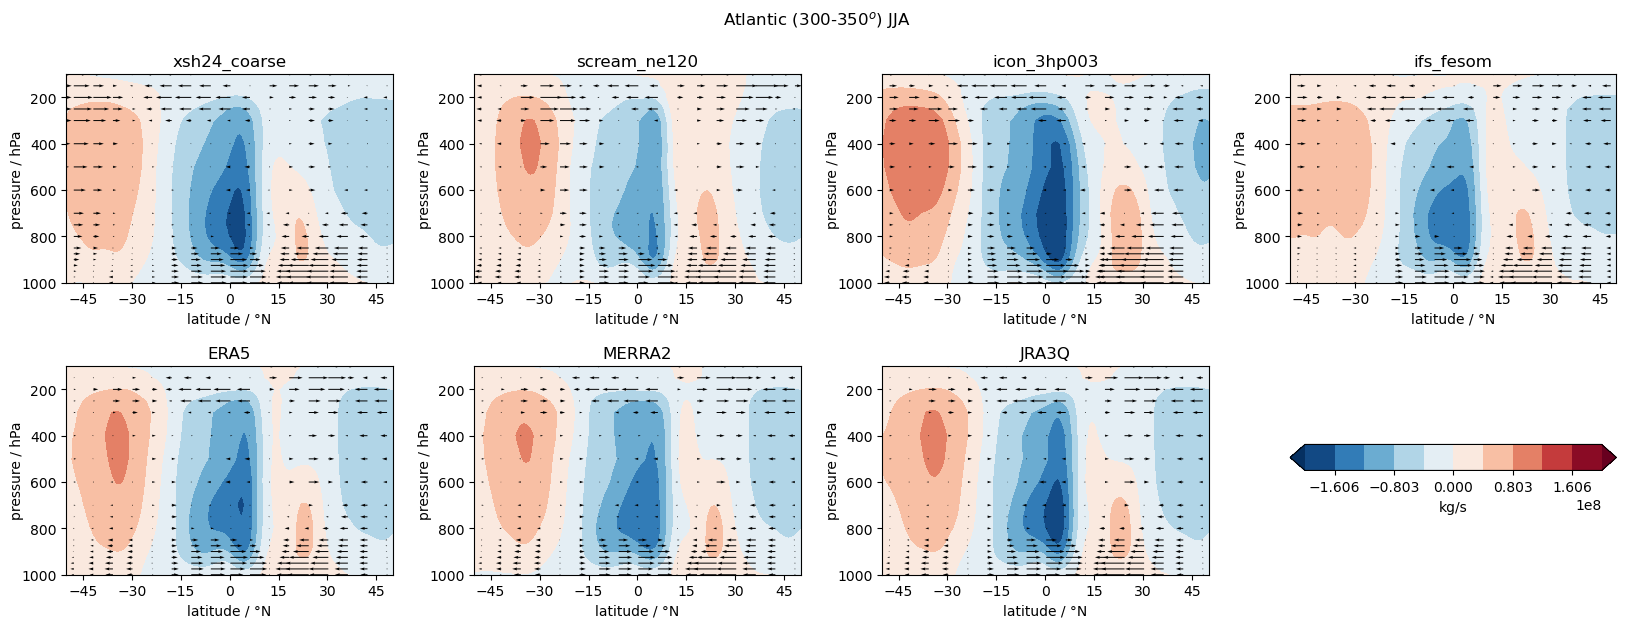

In [8]:
quiver_skip = 12
psi = atl_jja_psi
v = atl_jja_va
maxval = abs(psi).max().values
levs = np.linspace(-maxval, maxval, 11)

fig, axes = plt.subplots(2,4, figsize=(20,6.5),)
fig.subplots_adjust(hspace=0.4, wspace=0.25)
for i in range(psi.sizes['model']):
    plt.sca(axes.flatten()[i])
    
    contour = plt.contourf(psi.lat, psi.plev, psi.isel(model=i).T, levels=levs, cmap='RdBu_r', extend='both')
    
    plt.quiver(v.lat[::quiver_skip],
               v.plev,
               v.isel(model=i)[:,::quiver_skip],
               0*v.isel(model=i)[:,::quiver_skip],
               scale=1,scale_units='xy', width=0.003
              )
    plt.ylim(1000,100), plt.xlim(-50,50)
    plt.xlabel('latitude / \N{DEGREE SIGN}N')
    plt.ylabel('pressure / hPa', labelpad=-2)
    plt.title(atl_jja_psi.model.values[i])
    plt.xticks(np.arange(-45,55,15))

pos = axes[-1,-1].get_position()
axes[-1,-1].set_position([pos.x0, pos.y0+(pos.y1-pos.y0)/2, pos.x1-pos.x0, 0.04])
cb = plt.colorbar(contour, ax=axes, cax=axes[-1,-1], orientation='horizontal')
cb.set_label('kg/s')
fig.suptitle('Atlantic (300-350$^o$) JJA')

#plt.savefig('./mmc_figures/jja_atl_mc.png', dpi=250, bbox_inches='tight')

# west pacific

In [9]:
lon0 = 120
lon1 = 180
months = [6,7,8]
wpac_jja_psi = get_zonal_slice(lon0, lon1, ds.vdiv.sel(time=months).mean('time')).compute()
wpac_jja_va = ds.v.sel(lon=slice(lon0, lon1), time=months).mean(('time','lon')).compute()

Text(0.5, 0.98, 'W Pacific (120-180$^o$) JJA')

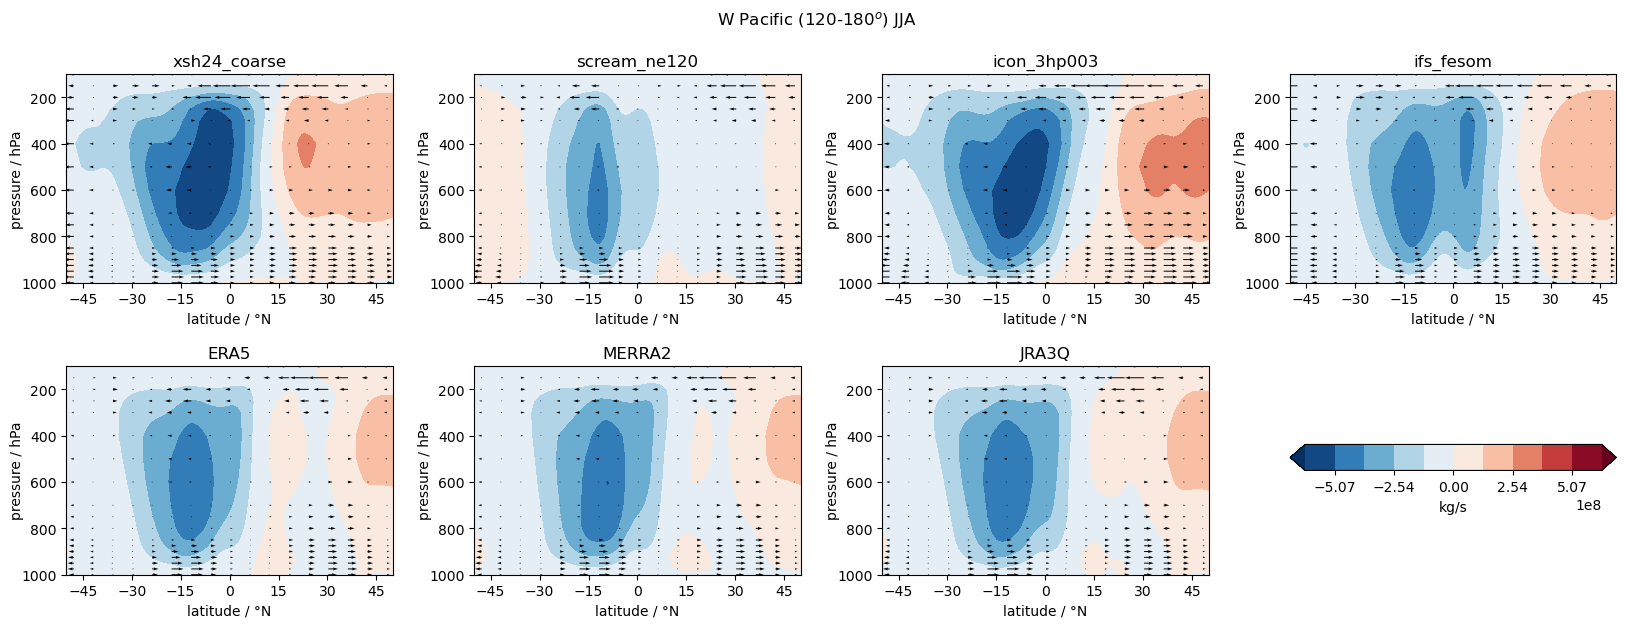

In [10]:
quiver_skip = 12
psi = wpac_jja_psi
v = wpac_jja_va
maxval = abs(psi).max().values
levs = np.linspace(-maxval, maxval, 11)

fig, axes = plt.subplots(2,4, figsize=(20,6.5),)
fig.subplots_adjust(hspace=0.4, wspace=0.25)
for i in range(psi.sizes['model']):
    plt.sca(axes.flatten()[i])
    
    contour = plt.contourf(psi.lat, psi.plev, psi.isel(model=i).T, levels=levs, cmap='RdBu_r', extend='both')
    
    plt.quiver(v.lat[::quiver_skip],
               v.plev,
               v.isel(model=i)[:,::quiver_skip],
               0*v.isel(model=i)[:,::quiver_skip],
               scale=1,scale_units='xy', width=0.003
              )
    plt.ylim(1000,100), plt.xlim(-50,50)
    plt.xlabel('latitude / \N{DEGREE SIGN}N')
    plt.ylabel('pressure / hPa', labelpad=-2)
    plt.title(atl_jja_psi.model.values[i])
    plt.xticks(np.arange(-45,55,15))

pos = axes[-1,-1].get_position()
axes[-1,-1].set_position([pos.x0, pos.y0+(pos.y1-pos.y0)/2, pos.x1-pos.x0, 0.04])
cb = plt.colorbar(contour, ax=axes, cax=axes[-1,-1], orientation='horizontal')
cb.set_label('kg/s')
fig.suptitle('W Pacific (120-180$^o$) JJA')

#plt.savefig('./mmc_figures/jja_wpac_mc.png', dpi=250, bbox_inches='tight')

# zonal mean annual mean

In [11]:
lon0 = 0
lon1 = 360
zm_am_psi = get_zonal_slice(lon0, lon1, ds.v.mean('time')).compute()
zm_am_va = ds.v.mean(('time','lon')).compute()

Text(0.5, 0.98, 'Annual Mean Meridional Circulation')

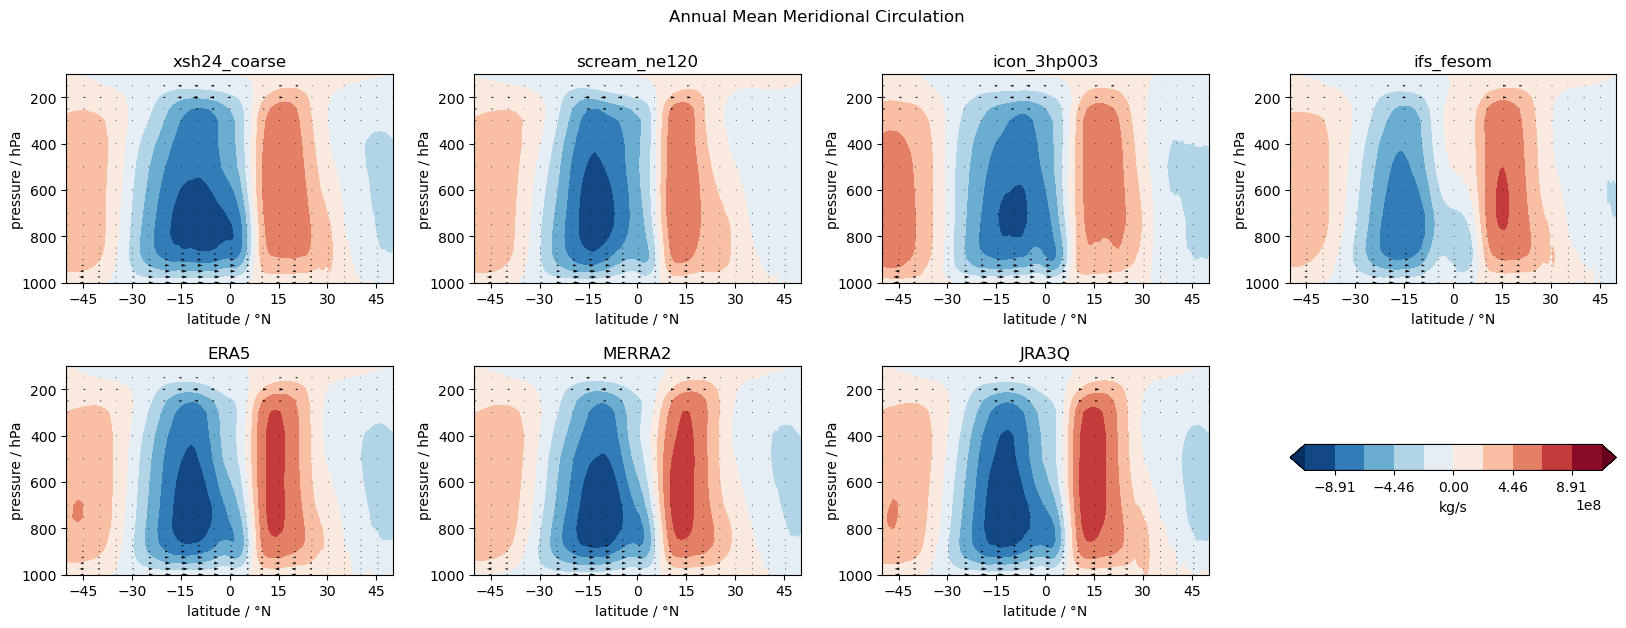

In [12]:
quiver_skip = 10
psi = zm_am_psi
v = zm_am_va
maxval = abs(psi).max().values
levs = np.linspace(-maxval, maxval, 11)

fig, axes = plt.subplots(2,4, figsize=(20,6.5),)
fig.subplots_adjust(hspace=0.4, wspace=0.25)
for i in range(psi.sizes['model']):
    plt.sca(axes.flatten()[i])
    
    contour = plt.contourf(psi.lat, psi.plev, psi.isel(model=i).T, levels=levs, cmap='RdBu_r', extend='both')
    
    plt.quiver(v.lat[::quiver_skip],
               v.plev,
               v.isel(model=i)[:,::quiver_skip],
               0*v.isel(model=i)[:,::quiver_skip],
               scale=1,scale_units='xy', width=0.003
              )
    plt.ylim(1000,100), plt.xlim(-50,50)
    plt.xlabel('latitude / \N{DEGREE SIGN}N')
    plt.ylabel('pressure / hPa', labelpad=-2)
    plt.title(atl_jja_psi.model.values[i])
    plt.xticks(np.arange(-45,55,15))

pos = axes[-1,-1].get_position()
axes[-1,-1].set_position([pos.x0, pos.y0+(pos.y1-pos.y0)/2, pos.x1-pos.x0, 0.04])
cb = plt.colorbar(contour, ax=axes, cax=axes[-1,-1], orientation='horizontal')
cb.set_label('kg/s')
fig.suptitle('Annual Mean Meridional Circulation')
#plt.savefig('annual_zonal_mmc.png', dpi=250, bbox_inches='tight')

# zonal mean JJA

In [13]:
lon0 = 0
lon1 = 360
months = [6,7,8]
jja_psi = get_zonal_slice(lon0, lon1, ds.vdiv.sel(time=months).mean('time')).compute()
jja_va = ds.v.sel(lon=slice(lon0, lon1), time=months).mean(('time','lon')).compute()

Text(0.5, 0.98, 'JJA Mean Meridional Circulation')

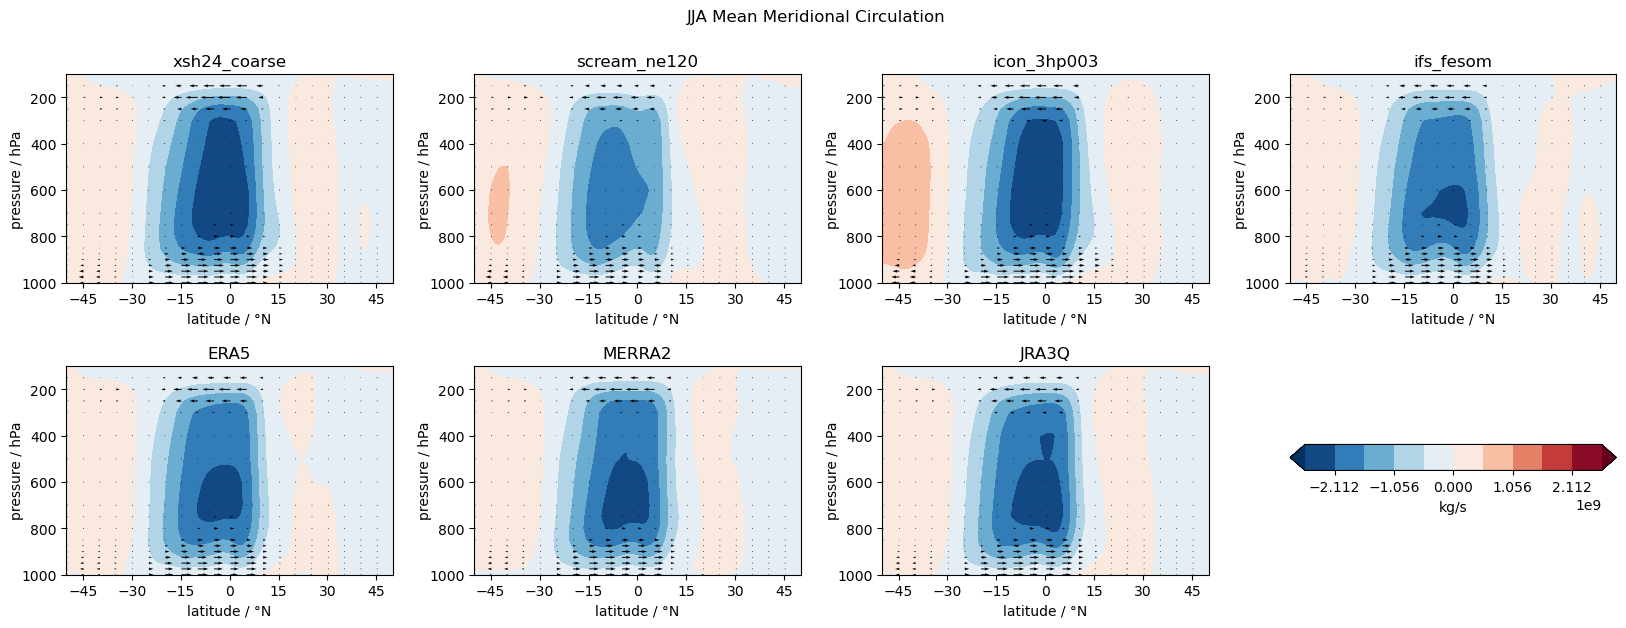

In [14]:
quiver_skip = 10
psi = jja_psi
v = jja_va
maxval = abs(psi).max().values
levs = np.linspace(-maxval, maxval, 11)

fig, axes = plt.subplots(2,4, figsize=(20,6.5),)
fig.subplots_adjust(hspace=0.4, wspace=0.25)
for i in range(psi.sizes['model']):
    plt.sca(axes.flatten()[i])
    
    contour = plt.contourf(psi.lat, psi.plev, psi.isel(model=i).T, levels=levs, cmap='RdBu_r', extend='both')
    
    plt.quiver(v.lat[::quiver_skip],
               v.plev,
               v.isel(model=i)[:,::quiver_skip],
               0*v.isel(model=i)[:,::quiver_skip],
               scale=1,scale_units='xy', width=0.003
              )
    plt.ylim(1000,100), plt.xlim(-50,50)
    plt.xlabel('latitude / \N{DEGREE SIGN}N')
    plt.ylabel('pressure / hPa', labelpad=-2)
    plt.title(atl_jja_psi.model.values[i])
    plt.xticks(np.arange(-45,55,15))

pos = axes[-1,-1].get_position()
axes[-1,-1].set_position([pos.x0, pos.y0+(pos.y1-pos.y0)/2, pos.x1-pos.x0, 0.04])
cb = plt.colorbar(contour, ax=axes, cax=axes[-1,-1], orientation='horizontal')
cb.set_label('kg/s')
fig.suptitle('JJA Mean Meridional Circulation')
#plt.savefig('annual_zonal_mmc.png', dpi=250, bbox_inches='tight')

# zonal mean DJF

In [15]:
lon0 = 0
lon1 = 360
months = [1,2,12]
djf_psi = get_zonal_slice(lon0, lon1, ds.vdiv.sel(time=months).mean('time')).compute()
djf_va = ds.v.sel(lon=slice(lon0, lon1), time=months).mean(('time','lon')).compute()

Text(0.5, 0.98, 'DJF Mean Meridional Circulation')

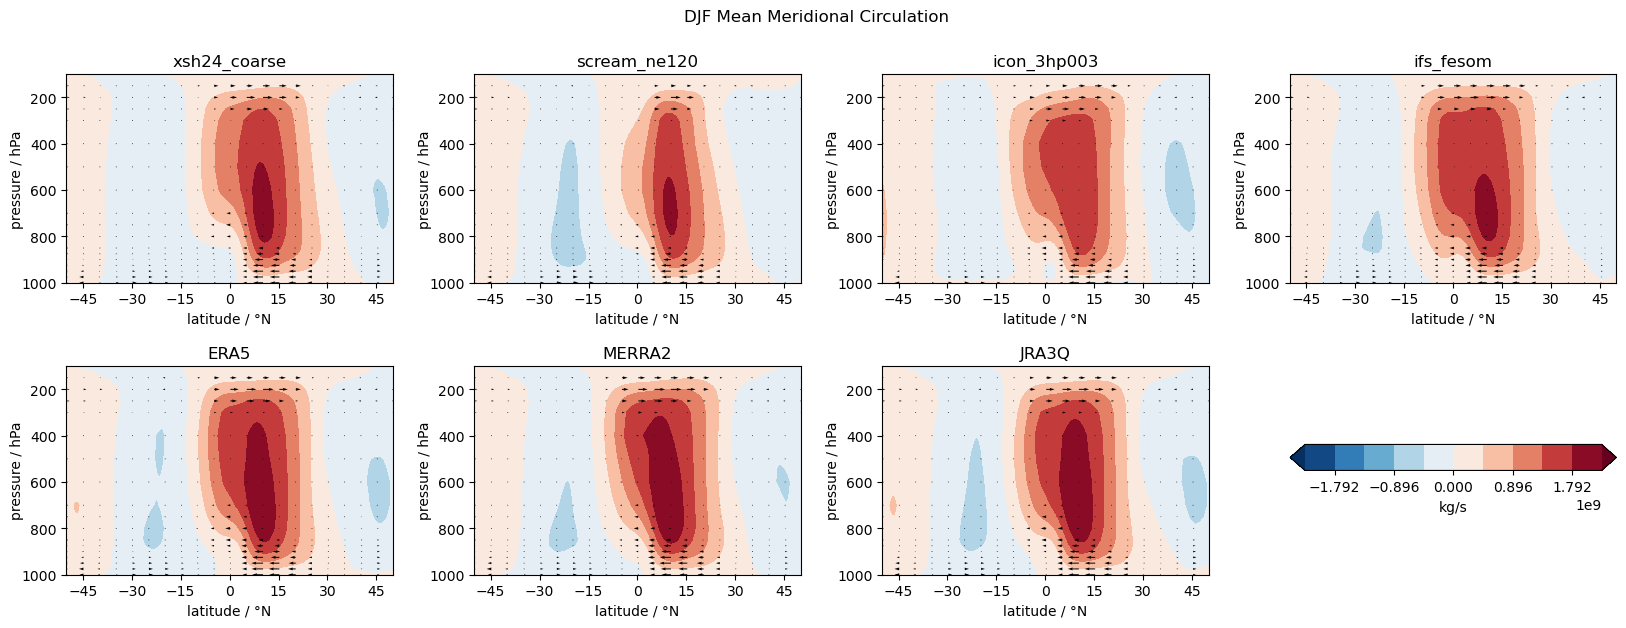

In [16]:
quiver_skip = 10
psi = djf_psi
v = djf_va
maxval = abs(psi).max().values
levs = np.linspace(-maxval, maxval, 11)

fig, axes = plt.subplots(2,4, figsize=(20,6.5),)
fig.subplots_adjust(hspace=0.4, wspace=0.25)
for i in range(psi.sizes['model']):
    plt.sca(axes.flatten()[i])
    
    contour = plt.contourf(psi.lat, psi.plev, psi.isel(model=i).T, levels=levs, cmap='RdBu_r', extend='both')
    
    plt.quiver(v.lat[::quiver_skip],
               v.plev,
               v.isel(model=i)[:,::quiver_skip],
               0*v.isel(model=i)[:,::quiver_skip],
               scale=1,scale_units='xy', width=0.003
              )
    plt.ylim(1000,100), plt.xlim(-50,50)
    plt.xlabel('latitude / \N{DEGREE SIGN}N')
    plt.ylabel('pressure / hPa', labelpad=-2)
    plt.title(atl_jja_psi.model.values[i])
    plt.xticks(np.arange(-45,55,15))

pos = axes[-1,-1].get_position()
axes[-1,-1].set_position([pos.x0, pos.y0+(pos.y1-pos.y0)/2, pos.x1-pos.x0, 0.04])
cb = plt.colorbar(contour, ax=axes, cax=axes[-1,-1], orientation='horizontal')
cb.set_label('kg/s')
fig.suptitle('DJF Mean Meridional Circulation')
#plt.savefig('annual_zonal_mmc.png', dpi=250, bbox_inches='tight')

In [77]:
ds = xr.open_dataset('helmholtz_monthly_winds/MERRA2_2020.nc').transpose('plev','lat','lon','time')
int = integrate.cumulative_trapezoid(ds.vdiv, ds.plev, axis=0, initial=0)
ds['psi_loc'] = (1/const.g) * xr.DataArray(int, coords={'plev':ds.plev, 'lat':ds.lat, 'lon':ds.lon, 'time':ds.time})


In [78]:
lon0, lon1 = 235, 255
v = ds.vdiv
factor = ((lon1-lon0)/360) * 2 * np.pi * const.a * np.cos(np.deg2rad(ds.lat)) / const.g
vbar = v.sel(lon=slice(lon0, lon1)).mean('lon')
v_int = integrate.cumulative_trapezoid(vbar, ds.plev, axis=0, initial=0)
if 'time' in v.sizes:
    psi = factor * xr.DataArray(v_int, coords={'plev':ds.plev, 'lat':ds.lat, 'time':ds.time, })
else:
    psi = factor * xr.DataArray(v_int, coords={'plev':ds.plev, 'lat':ds.lat,})

(-30.0, 35.0)

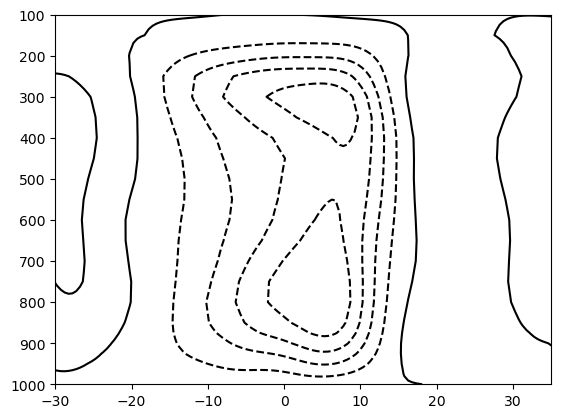

In [81]:
t = '2020-08'
p = psi.sel(time=t).squeeze()
#rh = ds.r.sel(time=t, lon=slice(lon0, lon1)).mean('lon').squeeze()

maxval = abs(p).max().values
levs = np.linspace(-maxval, maxval, 11)

plt.figure()
#plt.contourf(rh.lat, rh.plev, rh, levels=np.arange(0,110,10), cmap='BrBG')

plt.contour(p.lat, p.plev, p.T, levels=levs, colors=['k'])
plt.ylim(1000, 100)
plt.xlim(-30, 35)

#psi.sel(time='2021-08').plot(y='plev')